In [1]:
# install converter package
# see https://onnx.ai/sklearn-onnx/introduction.html

#!pip install --user skl2onnx

# after installation, need to restart the session and make sure to tick 'use python packages installed in CERNBox'

In [2]:
# general imports

import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt

from nmf2d import NMF2D

Shape of X_train: (10, 10, 10)


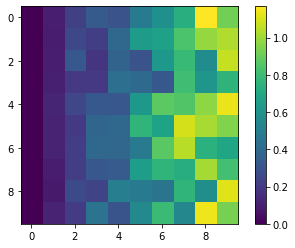

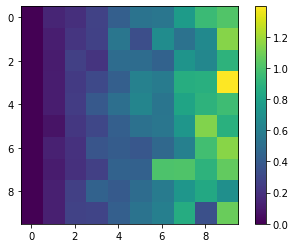

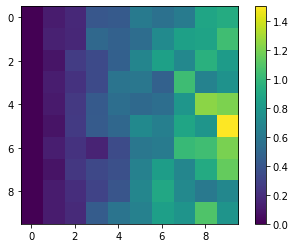

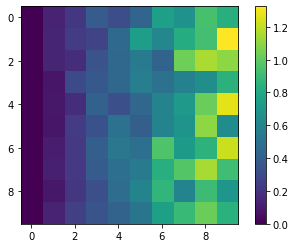

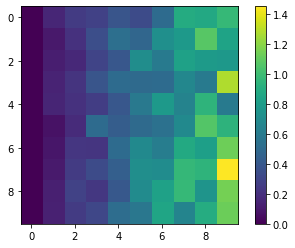

In [3]:
# make some toy data

data_shape = (10, 10)
n_instances = 10
xax = np.linspace(0, 1, num=data_shape[0])
y = xax
noise = rng.normal(scale=0.2*y, size=(n_instances, *data_shape))
X_train = y + noise
print(f'Shape of X_train: {X_train.shape}')

# make a plot
for idx in range(min(5, n_instances)):
    fig, ax = plt.subplots()
    plot = ax.imshow(X_train[idx])
    fig.colorbar(plot)

Text(0, 1.02, 'Reco')

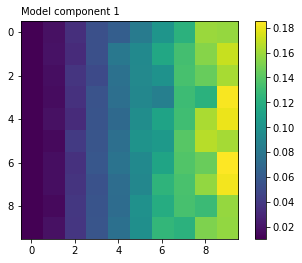

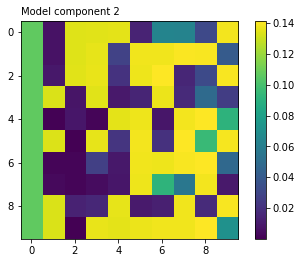

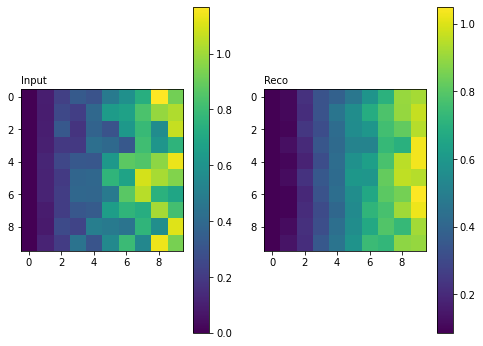

In [4]:
# make an NMF2D model

# make NMF
nmf = NMF2D(
  n_components = 2,
  batch_size = 5
)

# fit to data
_ = nmf.fit(X_train)
# normalization of the components
# (note: appears to be needed to make the onnx output match the native output,
#  but try to do more elegantly later)
norms = np.linalg.norm(nmf.components, axis=(1,2))
nmf.components = np.divide(nmf.components, norms[:,None,None])
nmf.nmf.components_ = np.divide(nmf.nmf.components_, norms[:,None])

# plot components
for i in range(nmf.components.shape[0]):
    fig, ax = plt.subplots()
    plot = ax.imshow(nmf.components[i])
    fig.colorbar(plot)
    ax.text(0, 1.02, f'Model component {i+1}', transform=ax.transAxes, ha='left', va='bottom')

# get transformed and reverse-transformed data for comparison later
X_pred = nmf.predict(X_train)

# plot an example
fig, axs = plt.subplots(figsize=(8,6), ncols=2)
idx = 0
plot = axs[0].imshow(X_train[idx])
fig.colorbar(plot)
axs[0].text(0, 1.02, f'Input', transform=axs[0].transAxes, ha='left', va='bottom')
plot = axs[1].imshow(X_pred[idx])
fig.colorbar(plot)
axs[1].text(0, 1.02, f'Reco', transform=axs[1].transAxes, ha='left', va='bottom')

In [5]:
# wrap model and register the converter

from skl2onnx import update_registered_converter
from nmf2d_onnx import NMF2DTransformWrapper
from nmf2d_onnx import skl2onnx_shape_calculator
from nmf2d_onnx import skl2onnx_converter

nmf_wrapped = NMF2DTransformWrapper(nmf)

update_registered_converter(
    NMF2DTransformWrapper, "NMF2DTransformWrapper",
    skl2onnx_shape_calculator,
    skl2onnx_converter)

In [6]:
# convert model to ONNX

from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn

initial_type = [
    ('input', FloatTensorType([None, *X_train.shape[1:]])),
]
nmf_onnx = convert_sklearn(nmf_wrapped, initial_types=initial_type)
with open('test.onnx', "wb") as f:
    f.write(nmf_onnx.SerializeToString())

In [7]:
# read ONNX model and run inference

import onnxruntime as rt

session = rt.InferenceSession("test.onnx", providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name
label_name = session.get_outputs()[0].name
pred_onnx = session.run([label_name], {input_name: X_train.astype(np.float32)})[0]

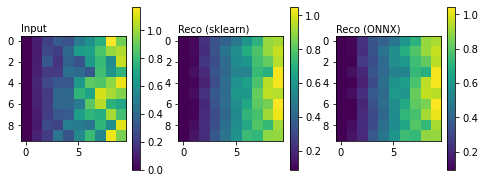

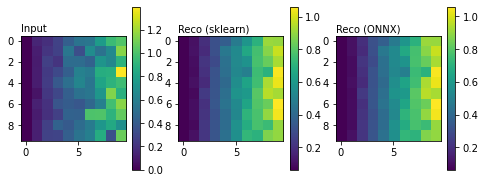

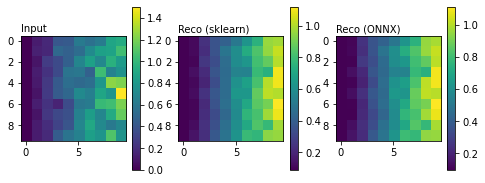

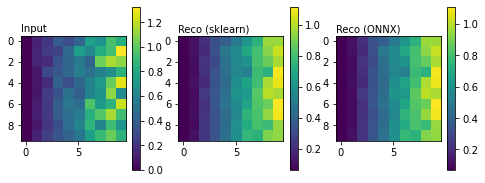

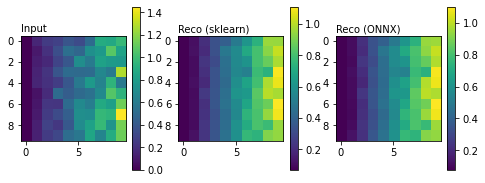

In [8]:
# compare direct transform with detour via ONNX

for idx in range(min(5, n_instances)):
    fig, axs = plt.subplots(figsize=(8,3), ncols=3)
    plot = axs[0].imshow(X_train[idx])
    fig.colorbar(plot)
    axs[0].text(0, 1.02, f'Input', transform=axs[0].transAxes, ha='left', va='bottom')
    plot = axs[1].imshow(X_pred[idx])
    fig.colorbar(plot)
    axs[1].text(0, 1.02, f'Reco (sklearn)', transform=axs[1].transAxes, ha='left', va='bottom')
    plot = axs[2].imshow(pred_onnx[idx])
    fig.colorbar(plot)
    axs[2].text(0, 1.02, f'Reco (ONNX)', transform=axs[2].transAxes, ha='left', va='bottom')